# Import

In [44]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import statsmodels.api as sm
import numpy as np
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [16]:
df = pd.read_csv('E:/My date/Skillfactory/Course/IDE/ML-инженер/Data/tea_demand.csv', sep="\t")   

# 0.Introduction

Оценить, есть ли влияние от рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.

- Произведён парсинг данных о датах проведения передачи «Что? Где? Когда?»
- Построена модель, предсказывающая значение временного ряда продаж. Показано, что нет положительного misprediction.
- Построен boxplot, указано, что нет аномалии роста продаж после передачи.
- Сделана попытка кластеризации точек продаж (по всем трём вендорам)

# 1.Funcions

In [15]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = pd.DatetimeIndex(df.index).isocalendar().week.astype("int64")
    df['game'] = df['game']
    
    X = df[['dayofweek','quarter','month',
           'dayofyear','dayofmonth','weekofyear', 'game']]
    if label:
        y = df[label]
        return X, y
    return X

# 2. Data

In [21]:
df

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185
...,...,...,...
454,178,2016-11-29,222
455,29,2016-11-29,1173
456,5152,2016-11-30,311
457,178,2016-11-30,227


In [23]:
df['date'] = pd.to_datetime(df.date)
df['date'] = df.date.sort_values(ascending=False)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        459 non-null    int64         
 1   date            459 non-null    datetime64[ns]
 2   receipts_count  459 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.9 KB


# 3.Parsing

Прежде чем приступать к парсингу дат проведения игры "Что? Где? Когда?" определим временные границы имеющихся сведений о продажах.

In [25]:
print("Первая дата наблюдений: ",df['date'].min())
print("Последняя дата наблюдений: ",df['date'].max())

Первая дата наблюдений:  2016-07-01 00:00:00
Последняя дата наблюдений:  2016-11-30 00:00:00


In [30]:
url = 'http://chgk.tvigra.ru/letopis/?2016'
page = requests.get(url)
soup = BS(page.text,'html.parser')
table_content = soup.find_all('li')

In [31]:
list_chgk = []
for el in table_content:
                list_chgk.append(el.select_one('a').get('href')[-5:]) 
        
games_2016 = pd.DataFrame(list_chgk, columns = ['date'])

In [32]:
games_2016['date'] = games_2016['date']+'2016'
games_2016['date'] = pd.to_datetime(games_2016['date'])
games_2016.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    20 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 288.0 bytes


In [33]:
games_2016

,date
0,2016-03-27
1,2016-04-03
2,2016-04-10
3,2016-04-17
4,2016-04-24
5,2016-05-15
6,2016-05-22
7,2016-05-29
8,2016-06-05
9,2016-06-19


In [34]:
games_2016['brand'] = 'game'
games_2016['count'] = 1
games_2016 = games_2016.reindex(columns=['brand', 'date', 'count'])
games_2016.head()

,brand,date,count
0,game,2016-03-27,1
1,game,2016-04-03,1
2,game,2016-04-10,1
3,game,2016-04-17,1
4,game,2016-04-24,1


In [35]:
games_2016 = games_2016.loc[(games_2016['date']>='2016-07-01')&(games_2016['date']<='2016-11-30')]

# 4.Preprocessing

Проведем визуализацию данных и добавим данные проведение игр.

In [36]:
#Vendor mapping
df = df.replace({'brand_id':
                {29: 'lipton',
                178: 'ahmad',
                5152: 'may'}})
#Columns naming
df = df.rename(columns = {'brand_id': 'brand', 'receipts_count': 'count'})

In [37]:
#Adding game data
df_conc = pd.concat([df, games_2016])
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 0 to 16
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   brand   466 non-null    object        
 1   date    466 non-null    datetime64[ns]
 2   count   466 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 14.6+ KB


In [38]:
df_conc.head()

,brand,date,count
0,may,2016-07-01,98
1,ahmad,2016-07-01,234
2,lipton,2016-07-01,622
3,may,2016-07-02,87
4,ahmad,2016-07-02,185


In [39]:
#Pivoting
pivot_df = pd.pivot_table(df_conc,values='count',index='date',columns='brand')
pivot_df = pivot_df.fillna(0)
pivot_df.head()

brand,ahmad,game,lipton,may
date,,,,
2016-07-01,234.0,0.0,622.0,98.0
2016-07-02,185.0,0.0,580.0,87.0
2016-07-03,190.0,0.0,687.0,105.0
2016-07-04,196.0,0.0,550.0,141.0
2016-07-05,336.0,0.0,529.0,137.0


# 5.Visualisation

In [40]:
#Filling date of games with Ahmad count
need_dates = games_2016.date.to_list()
filling_game = df[df.date.isin(need_dates)]
filling_game = filling_game[filling_game.brand == 'ahmad']
filling_game['brand'] = 'game'
filling_game

,brand,date,count
259,game,2016-09-25,223
280,game,2016-10-02,239
301,game,2016-10-09,401
322,game,2016-10-16,262
343,game,2016-10-23,238
427,game,2016-11-20,262
448,game,2016-11-27,229


In [41]:
#Adding game
vis_df = pd.concat([df, filling_game])

In [42]:
#Pivoting
vis_df = pd.pivot_table(vis_df,values='count',index='date',columns='brand')
vis_df.head()

brand,ahmad,game,lipton,may
date,,,,
2016-07-01,234.0,NaN,622.0,98.0
2016-07-02,185.0,NaN,580.0,87.0
2016-07-03,190.0,NaN,687.0,105.0
2016-07-04,196.0,NaN,550.0,141.0
2016-07-05,336.0,NaN,529.0,137.0


Text(0.5, 1.0, 'График продаж чая и проведения игр ЧТО? ГДЕ? КОГДА?')

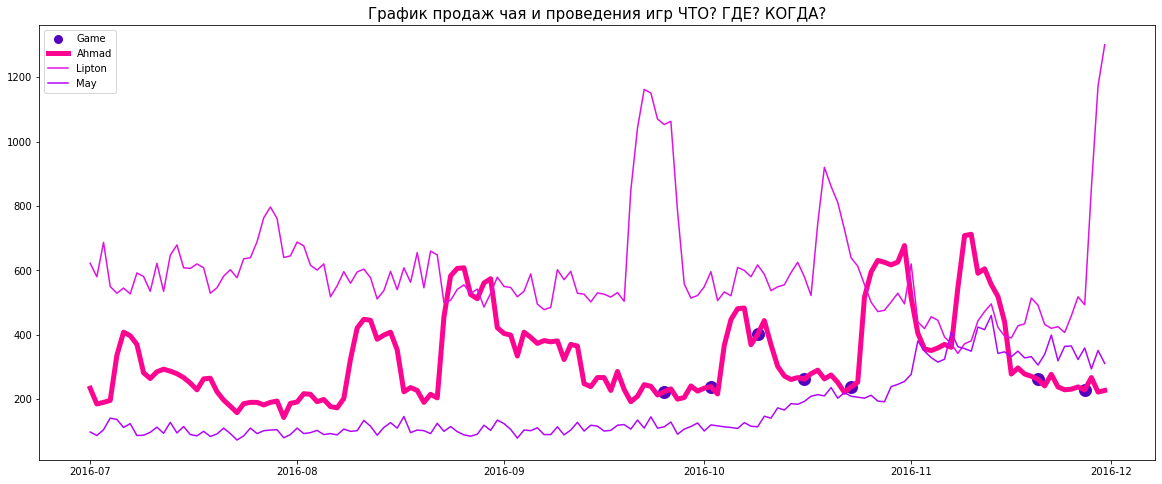

In [43]:
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots() 
x = vis_df.index
ax.scatter(x, vis_df['game'], c='#5204BF', lw=3) 
ax.plot(x, vis_df['ahmad'], c='#FC0590', lw=5) 
ax.plot(x, vis_df['lipton'], c='#DE11E6') 
ax.plot(x, vis_df['may'], c='#B105FC') 
ax.scatter(x, vis_df['game'], c='#5204BF', lw=7) 
ax.legend(['Game', 'Ahmad', 'Lipton','May'])
ax.set_title('График продаж чая и проведения игр ЧТО? ГДЕ? КОГДА?', fontsize=15)

Существует некая корреляция между играми и продаж чая Ахмат.
Проведет декомпозицию данных.

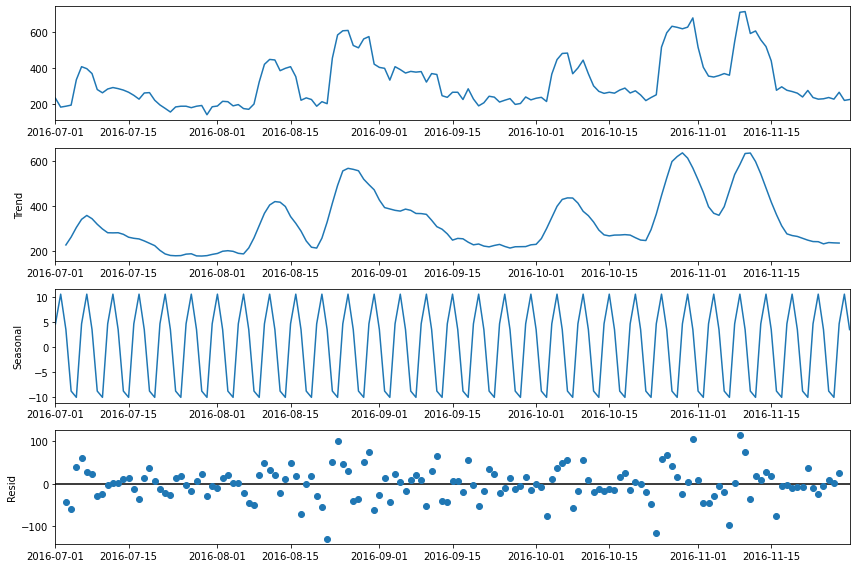

In [45]:
ahmad_df = pivot_df['ahmad'].to_frame()
decomposition = seasonal_decompose(ahmad_df, period=5, model='additive')
plt.rcParams["figure.figsize"] = (12,8)
decomposition.plot()
plt.show()

Временный ряд нестационарен, также отсутствуют повторящихся потернов.

In [46]:
test = adfuller(ahmad_df['ahmad'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -2.1957361074439206
p-value:  0.20779664213973803
Critical values:  {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
ряд не стационарен


Посколькую ряд не стационарен, будем использовать модель SARIMAX.

# 6.Prediction

In [48]:
#Model
model=sm.tsa.statespace.SARIMAX(ahmad_df['ahmad'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [49]:
#Predicting
ahmad_df['forecast']=results.predict()
ahmad_df.head(3)

,ahmad,forecast
date,,
2016-07-01,234.0,0.000000
2016-07-02,185.0,234.191827
2016-07-03,190.0,184.861084


In [51]:
#Anomaly classification
ahmad_df['anomaly_precentage']=(ahmad_df['ahmad']-ahmad_df['forecast'])/ahmad_df['ahmad'] * 100
ahmad_df['anomaly_precentage'] = abs(ahmad_df['anomaly_precentage'])
ahmad_df.describe()

,ahmad,forecast,anomaly_precentage
count,153.000000,153.000000,153.000000
mean,327.045752,326.969697,15.269985
std,134.810703,140.458785,15.311582
min,143.000000,0.000000,0.061864
25%,227.000000,223.283130,5.557804
50%,275.000000,281.856785,10.012553
75%,399.000000,407.765860,20.157279
max,712.000000,733.584673,100.000000


In [52]:
ahmad_df.head()

,ahmad,forecast,anomaly_precentage
date,,,
2016-07-01,234.0,0.000000,100.000000
2016-07-02,185.0,234.191827,26.590177
2016-07-03,190.0,184.861084,2.704693
2016-07-04,196.0,190.050779,3.035317
2016-07-05,336.0,195.994255,41.668377


In [53]:
anomaly = ahmad_df[ahmad_df.anomaly_precentage>40]
anomaly['is_anomaly'] = anomaly['ahmad']
anomaly = anomaly.is_anomaly.to_frame()
anomaly['date']=anomaly.index

C:\Users\askar\AppData\Local\Temp\ipykernel_16252\4055465431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly['is_anomaly'] = anomaly['ahmad']


Text(0.5, 1.0, 'Прогноз продаж Ahmad и график проведения игр Что? Где? Когда?')

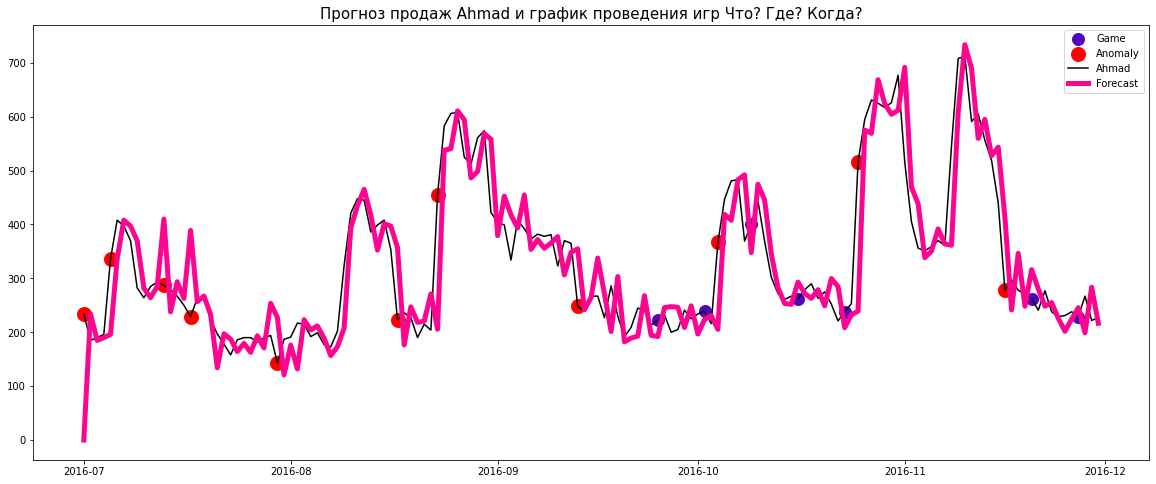

In [54]:
#Adding anomaly to frame
ahmad_df = ahmad_df.join(anomaly.set_index('date'), on='date')
#Plotting
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots() 
x = vis_df.index
ax.scatter(x, vis_df['game'], c='#5204BF', lw=7)
ax.scatter(x, ahmad_df['is_anomaly'], c='red', lw=9)
ax.plot(x, ahmad_df['ahmad'], c='black') 
ax.plot(x, ahmad_df['forecast'], c='#FC0590', lw=5) 
ax.legend(['Game', 'Anomaly', 'Ahmad', 'Forecast'])
ax.set_title('Прогноз продаж Ahmad и график проведения игр Что? Где? Когда?', fontsize=15)

Прогноз продаж чая Ахмад показывает, что только 2 из аномально высоких точек спроса имеют прямую корреляцию с проведением игры "Что? Где? Когда?"

Это говорит о том, что в октябре телереклама имела прямое влияние на повышение продаж, в других месяцах - нет.

# 7.Boxplot

<AxesSubplot: >

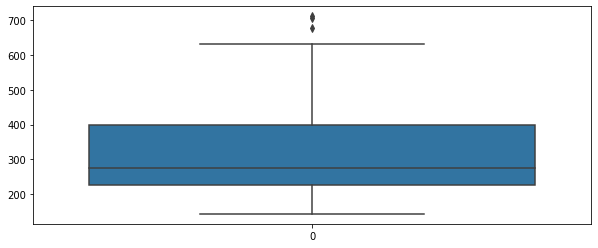

In [55]:
plt.rcParams["figure.figsize"] = (10,4)
sns.boxplot(ahmad_df['ahmad'])

Выбросы наблюдается после 630 единиц продукции в день.

# 8.Clustering

## 8.1 Ahmad

In [56]:
#Clustering and plotting function
def get_cluster_plot(label, data):
    
    #separate brand df
    label_df = data[[label, 'game']]
    
    #date features creating
    label_df['date'] = label_df.index
    label_df['dayofweek'] = label_df['date'].dt.dayofweek
    label_df['quarter'] = label_df['date'].dt.quarter
    label_df['month'] = label_df['date'].dt.month
    label_df['dayofyear'] = label_df['date'].dt.dayofyear
    label_df['dayofmonth'] = label_df['date'].dt.day
    label_df = label_df.reset_index(drop=True)
    label_df = label_df.drop('date', axis=1)
    
    #Isolation Forest fitting
    from sklearn.ensemble import IsolationForest
    clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    
    clf.fit(label_df)
    
    pred = clf.predict(label_df)
    label_df['anomaly']=pred
    outliers=label_df.loc[label_df['anomaly']==-1]
    outlier_index=list(outliers.index)
    
    #Clustering scatter plotting
    
    pca = PCA(2)
    pca.fit(label_df)


    res=pd.DataFrame(pca.transform(label_df))

    Z = np.array(res)
    figsize=(12, 7)
    plt.figure(figsize=figsize)
    plt.title("IsolationForest" +' '+ label)
    plt.contourf( Z, cmap=plt.cm.Blues_r)

    b1 = plt.scatter(res[0], res[1], c='blue',
                 s=40,label="normal points")

    b1 = plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',
                 s=40,  edgecolor="red",label="predicted outliers")
    plt.legend(loc="upper right")
    return plt.show()

C:\Users\askar\AppData\Local\Temp\ipykernel_16252\887509770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['date'] = label_df.index


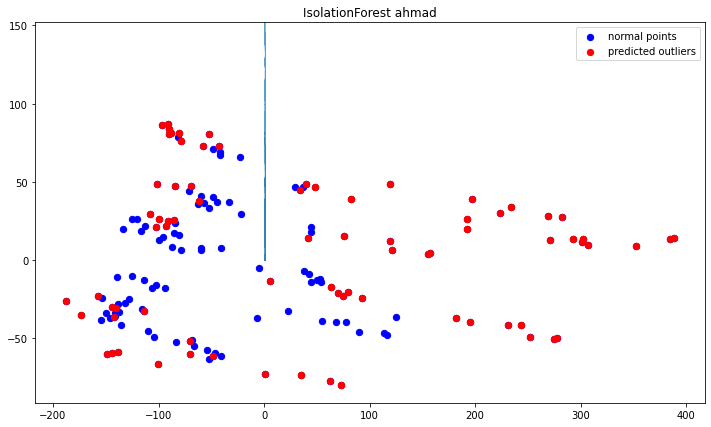

In [57]:
label = 'ahmad'
data = pivot_df

get_cluster_plot(label, data)

## 8.2 Lipton

C:\Users\askar\AppData\Local\Temp\ipykernel_16252\887509770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['date'] = label_df.index


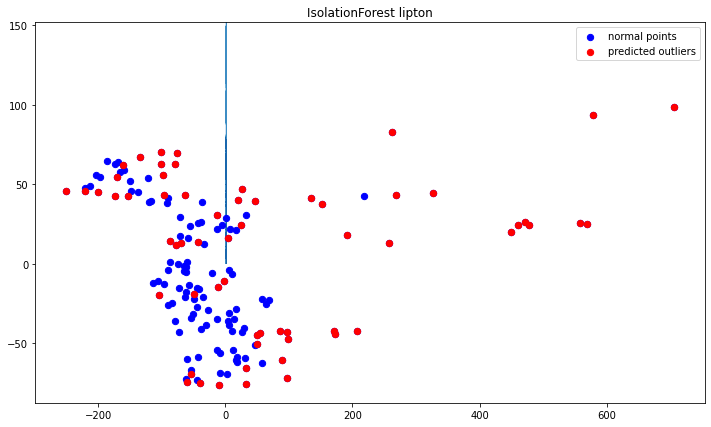

In [58]:
label = 'lipton'
data = pivot_df

get_cluster_plot(label, data)

## 8.3 May

C:\Users\askar\AppData\Local\Temp\ipykernel_16252\887509770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['date'] = label_df.index


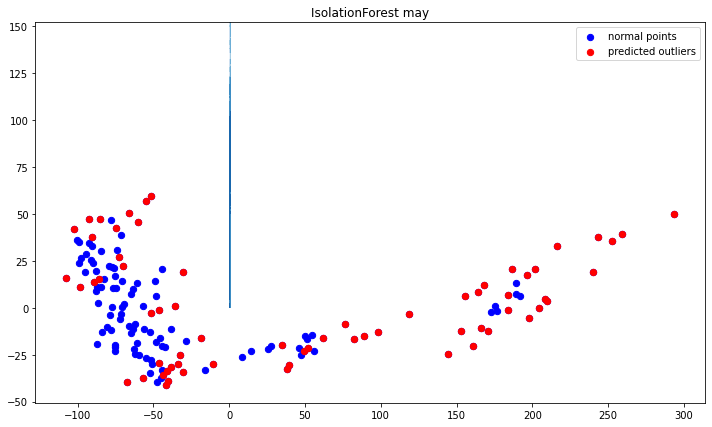

In [59]:
label = 'may'
data = pivot_df

get_cluster_plot(label, data)